# vanilla GAN

In [ ]:
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.reshape(-1, 28, 28, 1) - 127.5) / 127.5
x_test = (x_test.reshape(-1, 28, 28, 1) - 127.5) / 127.5
print(x_train.shape, x_train[0].min(), x_train[0].max())
print(x_test.shape, x_test[0].min(), x_test[0].max())

(60000, 28, 28, 1) -1.0 1.0
(10000, 28, 28, 1) -1.0 1.0


In [ ]:
# 판별기 
def make_discriminator():
    dx = tf.keras.Input(shape=[28 * 28])
    dh = tf.keras.layers.Dense(128)(dx)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Dense(128)(dh)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dy = tf.keras.layers.Dense(1, activation='sigmoid')(dh)
    return tf.keras.Model(dx, dy, name='discriminator')

# 생성기 
def make_generator():
    gx = tf.keras.Input(shape=[100])
    gh = tf.keras.layers.Dense(128)(gx)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gh = tf.keras.layers.Dense(128,)(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gy = tf.keras.layers.Dense(28 * 28, activation='tanh')(gh)
    return tf.keras.Model(gx, gy, name='generator')


In [ ]:
class VanillaGAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(VanillaGAN, self).__init__()

        self.generator = generator
        self.discriminator = discriminator

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.d_acc_metric = tf.keras.metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.g_acc_metric = tf.keras.metrics.BinaryAccuracy(name="g_acc")

        self.compile()

    def discriminator_loss(self, y_real, y_fake):
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_real), y_real)
        fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(y_fake), y_fake)
        d_loss = real_loss + fake_loss
        return d_loss

    def generator_loss(self, y_fake):
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_fake), y_fake)
        return g_loss
    
    def update_metrics(self, y_real, y_fake, g_loss, d_loss):
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(tf.ones_like(y_fake), y_fake)
        self.d_loss_metric.update_state(d_loss)
        self.d_acc_metric.update_state(tf.ones_like(y_real), y_real)
        self.d_acc_metric.update_state(tf.zeros_like(y_fake), y_fake)

    def train_step(self, real):
        noise = tf.random.normal([tf.shape(real)[0], 100])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake = self.generator(noise)

            y_real = self.discriminator(real)
            y_fake = self.discriminator(fake)

            g_loss = self.generator_loss(y_fake)
            d_loss = self.discriminator_loss(y_real, y_fake)

            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        self.update_metrics(y_real, y_fake, g_loss, d_loss)
        return {
            "d_acc": self.d_acc_metric.result(),
            "g_acc": self.g_acc_metric.result(),
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class Monitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_rnd = np.random.randn(5 * 100).reshape(5, 100)
        generated = self.model.generator(x_rnd)
        for i in range(5):
            plt.subplot(1, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated[i].numpy().reshape(28, 28), cmap='gray_r')
        plt.show()

Epoch 1/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.8165 - g_acc: 0.2995 - d_loss: 0.8765 - g_loss: 0.8154

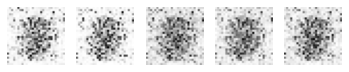

469/469 [==============================] - 7s 6ms/step - d_acc: 0.8165 - g_acc: 0.2990 - d_loss: 0.8772 - g_loss: 0.8156
Epoch 2/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.8982 - g_acc: 0.0968 - d_loss: 0.7147 - g_loss: 1.2516

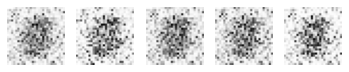

469/469 [==============================] - 3s 5ms/step - d_acc: 0.8980 - g_acc: 0.0975 - d_loss: 0.7142 - g_loss: 1.2524
Epoch 3/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.8778 - g_acc: 0.1135 - d_loss: 0.7157 - g_loss: 1.3508

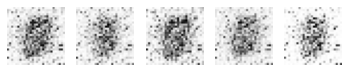

469/469 [==============================] - 3s 5ms/step - d_acc: 0.8785 - g_acc: 0.1120 - d_loss: 0.7149 - g_loss: 1.3504
Epoch 4/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.8928 - g_acc: 0.0746 - d_loss: 0.6755 - g_loss: 1.4272

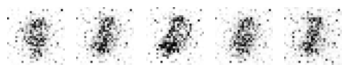

469/469 [==============================] - 3s 5ms/step - d_acc: 0.8927 - g_acc: 0.0745 - d_loss: 0.6756 - g_loss: 1.4280
Epoch 5/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.8673 - g_acc: 0.0932 - d_loss: 0.7197 - g_loss: 1.4552

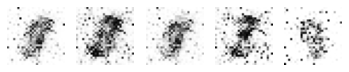

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8675 - g_acc: 0.0930 - d_loss: 0.7197 - g_loss: 1.4533
Epoch 6/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.8734 - g_acc: 0.0835 - d_loss: 0.7147 - g_loss: 1.4788

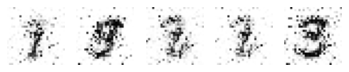

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8733 - g_acc: 0.0840 - d_loss: 0.7146 - g_loss: 1.4784
Epoch 7/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.8898 - g_acc: 0.0702 - d_loss: 0.6118 - g_loss: 1.7697

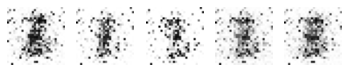

469/469 [==============================] - 3s 5ms/step - d_acc: 0.8896 - g_acc: 0.0700 - d_loss: 0.6124 - g_loss: 1.7692
Epoch 8/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.8954 - g_acc: 0.0746 - d_loss: 0.5802 - g_loss: 1.8499

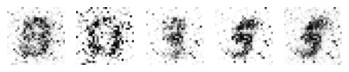

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8954 - g_acc: 0.0745 - d_loss: 0.5803 - g_loss: 1.8497
Epoch 9/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.8940 - g_acc: 0.0683 - d_loss: 0.5925 - g_loss: 1.8388

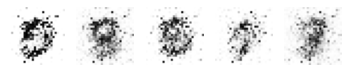

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8940 - g_acc: 0.0682 - d_loss: 0.5926 - g_loss: 1.8405
Epoch 10/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.8652 - g_acc: 0.1011 - d_loss: 0.6835 - g_loss: 1.7546

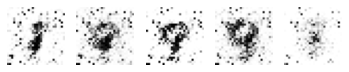

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8652 - g_acc: 0.1010 - d_loss: 0.6835 - g_loss: 1.7526
Epoch 11/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.8557 - g_acc: 0.1093 - d_loss: 0.7120 - g_loss: 1.6807

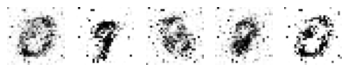

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8556 - g_acc: 0.1092 - d_loss: 0.7121 - g_loss: 1.6801
Epoch 12/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.8293 - g_acc: 0.1275 - d_loss: 0.8060 - g_loss: 1.5100

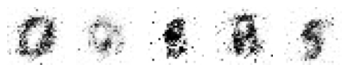

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8293 - g_acc: 0.1280 - d_loss: 0.8054 - g_loss: 1.5096
Epoch 13/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.8501 - g_acc: 0.1001 - d_loss: 0.7457 - g_loss: 1.5411

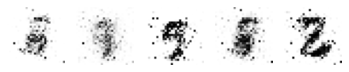

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8501 - g_acc: 0.1001 - d_loss: 0.7458 - g_loss: 1.5408
Epoch 14/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.8343 - g_acc: 0.1228 - d_loss: 0.7868 - g_loss: 1.5628

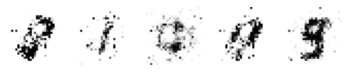

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8348 - g_acc: 0.1221 - d_loss: 0.7855 - g_loss: 1.5642
Epoch 15/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.8364 - g_acc: 0.1180 - d_loss: 0.7719 - g_loss: 1.6166

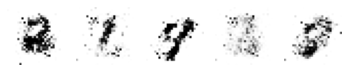

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8360 - g_acc: 0.1187 - d_loss: 0.7735 - g_loss: 1.6152
Epoch 16/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.8415 - g_acc: 0.1220 - d_loss: 0.7475 - g_loss: 1.6961

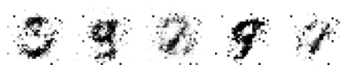

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8414 - g_acc: 0.1219 - d_loss: 0.7482 - g_loss: 1.6932
Epoch 17/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.8415 - g_acc: 0.1235 - d_loss: 0.7614 - g_loss: 1.6029

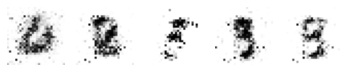

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8422 - g_acc: 0.1227 - d_loss: 0.7596 - g_loss: 1.6041
Epoch 18/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.8677 - g_acc: 0.0934 - d_loss: 0.6632 - g_loss: 1.7908

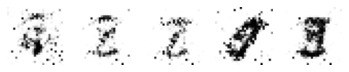

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8676 - g_acc: 0.0938 - d_loss: 0.6633 - g_loss: 1.7896
Epoch 19/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.8624 - g_acc: 0.1076 - d_loss: 0.6699 - g_loss: 1.9288

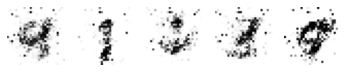

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8621 - g_acc: 0.1082 - d_loss: 0.6707 - g_loss: 1.9270
Epoch 20/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.8363 - g_acc: 0.1360 - d_loss: 0.7564 - g_loss: 1.7056

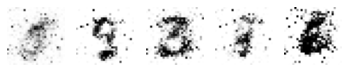

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8368 - g_acc: 0.1353 - d_loss: 0.7551 - g_loss: 1.7058
Epoch 21/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.8494 - g_acc: 0.1114 - d_loss: 0.7377 - g_loss: 1.6250

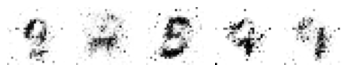

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8493 - g_acc: 0.1112 - d_loss: 0.7386 - g_loss: 1.6232
Epoch 22/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.8148 - g_acc: 0.1436 - d_loss: 0.8452 - g_loss: 1.4363

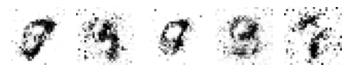

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8151 - g_acc: 0.1432 - d_loss: 0.8441 - g_loss: 1.4375
Epoch 23/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.8375 - g_acc: 0.1195 - d_loss: 0.7877 - g_loss: 1.4782

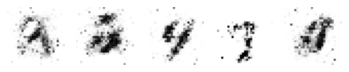

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8375 - g_acc: 0.1196 - d_loss: 0.7876 - g_loss: 1.4804
Epoch 24/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.8309 - g_acc: 0.1262 - d_loss: 0.7883 - g_loss: 1.5529

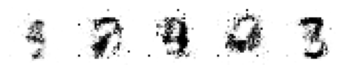

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8309 - g_acc: 0.1260 - d_loss: 0.7883 - g_loss: 1.5536
Epoch 25/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.8353 - g_acc: 0.1256 - d_loss: 0.7657 - g_loss: 1.6098

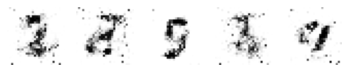

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8354 - g_acc: 0.1257 - d_loss: 0.7656 - g_loss: 1.6105
Epoch 26/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.8411 - g_acc: 0.1208 - d_loss: 0.7552 - g_loss: 1.6299

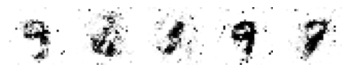

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8406 - g_acc: 0.1213 - d_loss: 0.7561 - g_loss: 1.6296
Epoch 27/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.8236 - g_acc: 0.1401 - d_loss: 0.8023 - g_loss: 1.6167

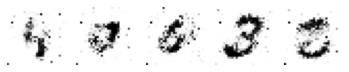

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8238 - g_acc: 0.1397 - d_loss: 0.8015 - g_loss: 1.6164
Epoch 28/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.8123 - g_acc: 0.1521 - d_loss: 0.8388 - g_loss: 1.5225

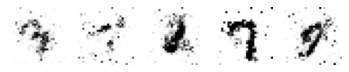

469/469 [==============================] - 3s 6ms/step - d_acc: 0.8119 - g_acc: 0.1525 - d_loss: 0.8402 - g_loss: 1.5210
Epoch 29/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7991 - g_acc: 0.1624 - d_loss: 0.8832 - g_loss: 1.3980

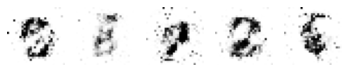

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7992 - g_acc: 0.1622 - d_loss: 0.8831 - g_loss: 1.3982
Epoch 30/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7929 - g_acc: 0.1733 - d_loss: 0.9052 - g_loss: 1.3680

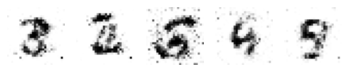

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7929 - g_acc: 0.1736 - d_loss: 0.9052 - g_loss: 1.3674
Epoch 31/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7874 - g_acc: 0.1735 - d_loss: 0.9108 - g_loss: 1.3788

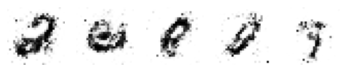

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7874 - g_acc: 0.1737 - d_loss: 0.9109 - g_loss: 1.3783
Epoch 32/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7756 - g_acc: 0.1877 - d_loss: 0.9449 - g_loss: 1.3361

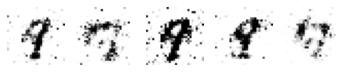

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7756 - g_acc: 0.1875 - d_loss: 0.9450 - g_loss: 1.3364
Epoch 33/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.7715 - g_acc: 0.1928 - d_loss: 0.9624 - g_loss: 1.2780

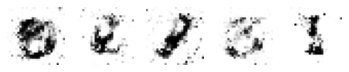

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7717 - g_acc: 0.1925 - d_loss: 0.9621 - g_loss: 1.2784
Epoch 34/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7651 - g_acc: 0.1966 - d_loss: 0.9834 - g_loss: 1.2550

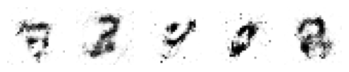

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7652 - g_acc: 0.1963 - d_loss: 0.9832 - g_loss: 1.2547
Epoch 35/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7613 - g_acc: 0.2026 - d_loss: 0.9909 - g_loss: 1.2411

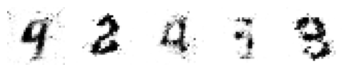

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7612 - g_acc: 0.2025 - d_loss: 0.9911 - g_loss: 1.2412
Epoch 36/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7668 - g_acc: 0.2025 - d_loss: 0.9788 - g_loss: 1.2531

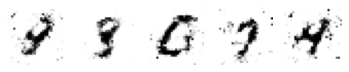

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7668 - g_acc: 0.2025 - d_loss: 0.9788 - g_loss: 1.2531
Epoch 37/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.7690 - g_acc: 0.1992 - d_loss: 0.9796 - g_loss: 1.2494

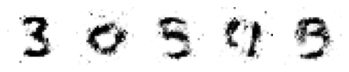

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7695 - g_acc: 0.1990 - d_loss: 0.9788 - g_loss: 1.2502
Epoch 38/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7671 - g_acc: 0.2038 - d_loss: 0.9825 - g_loss: 1.2326

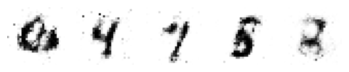

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7672 - g_acc: 0.2037 - d_loss: 0.9824 - g_loss: 1.2322
Epoch 39/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7611 - g_acc: 0.2067 - d_loss: 0.9947 - g_loss: 1.2240

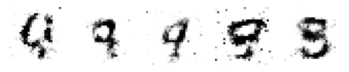

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7613 - g_acc: 0.2067 - d_loss: 0.9947 - g_loss: 1.2227
Epoch 40/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7422 - g_acc: 0.2271 - d_loss: 1.0451 - g_loss: 1.1817

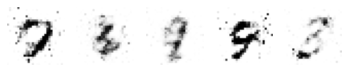

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7423 - g_acc: 0.2271 - d_loss: 1.0447 - g_loss: 1.1816
Epoch 41/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7412 - g_acc: 0.2330 - d_loss: 1.0494 - g_loss: 1.1710

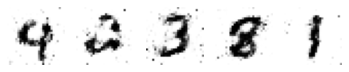

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7412 - g_acc: 0.2327 - d_loss: 1.0490 - g_loss: 1.1721
Epoch 42/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7474 - g_acc: 0.2300 - d_loss: 1.0340 - g_loss: 1.1798

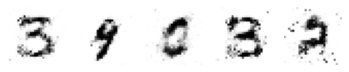

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7475 - g_acc: 0.2298 - d_loss: 1.0338 - g_loss: 1.1801
Epoch 43/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7438 - g_acc: 0.2356 - d_loss: 1.0453 - g_loss: 1.1777

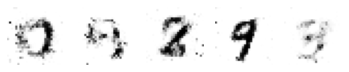

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7439 - g_acc: 0.2358 - d_loss: 1.0447 - g_loss: 1.1772
Epoch 44/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7424 - g_acc: 0.2335 - d_loss: 1.0455 - g_loss: 1.1622

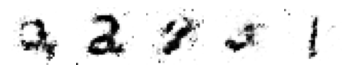

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7424 - g_acc: 0.2334 - d_loss: 1.0453 - g_loss: 1.1623
Epoch 45/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7360 - g_acc: 0.2425 - d_loss: 1.0588 - g_loss: 1.1540

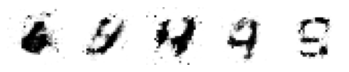

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7359 - g_acc: 0.2426 - d_loss: 1.0590 - g_loss: 1.1534
Epoch 46/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.7372 - g_acc: 0.2422 - d_loss: 1.0587 - g_loss: 1.1442

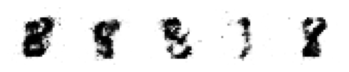

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7373 - g_acc: 0.2419 - d_loss: 1.0586 - g_loss: 1.1441
Epoch 47/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7412 - g_acc: 0.2340 - d_loss: 1.0497 - g_loss: 1.1497

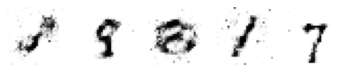

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7409 - g_acc: 0.2345 - d_loss: 1.0503 - g_loss: 1.1496
Epoch 48/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7402 - g_acc: 0.2367 - d_loss: 1.0472 - g_loss: 1.1532

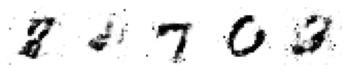

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7402 - g_acc: 0.2372 - d_loss: 1.0472 - g_loss: 1.1526
Epoch 49/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7433 - g_acc: 0.2353 - d_loss: 1.0455 - g_loss: 1.1566

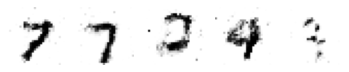

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7433 - g_acc: 0.2353 - d_loss: 1.0455 - g_loss: 1.1566
Epoch 50/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.7410 - g_acc: 0.2423 - d_loss: 1.0467 - g_loss: 1.1594

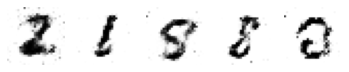

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7408 - g_acc: 0.2424 - d_loss: 1.0469 - g_loss: 1.1605


In [ ]:
tf.keras.backend.clear_session()

discriminator = make_discriminator()
generator = make_generator()
gan = VanillaGAN(generator, discriminator)
gan.fit(x_train.reshape(-1, 28 * 28), epochs=50, batch_size=128, callbacks=[Monitor()])

Epoch 1/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7451 - g_acc: 0.2381 - d_loss: 1.0445 - g_loss: 1.1616

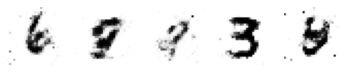

469/469 [==============================] - 4s 8ms/step - d_acc: 0.7448 - g_acc: 0.2382 - d_loss: 1.0449 - g_loss: 1.1624
Epoch 2/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7446 - g_acc: 0.2390 - d_loss: 1.0404 - g_loss: 1.1731

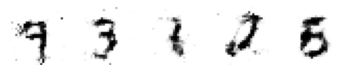

469/469 [==============================] - 2s 5ms/step - d_acc: 0.7445 - g_acc: 0.2389 - d_loss: 1.0405 - g_loss: 1.1726
Epoch 3/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7444 - g_acc: 0.2419 - d_loss: 1.0459 - g_loss: 1.1709

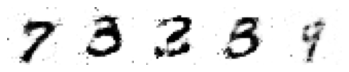

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7444 - g_acc: 0.2417 - d_loss: 1.0458 - g_loss: 1.1710
Epoch 4/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7483 - g_acc: 0.2375 - d_loss: 1.0377 - g_loss: 1.1725

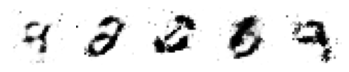

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7484 - g_acc: 0.2372 - d_loss: 1.0374 - g_loss: 1.1729
Epoch 5/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7457 - g_acc: 0.2393 - d_loss: 1.0400 - g_loss: 1.1693

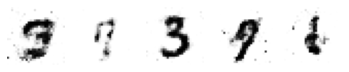

469/469 [==============================] - 2s 5ms/step - d_acc: 0.7457 - g_acc: 0.2394 - d_loss: 1.0400 - g_loss: 1.1692
Epoch 6/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7464 - g_acc: 0.2387 - d_loss: 1.0366 - g_loss: 1.1813

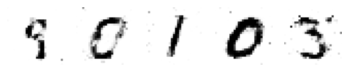

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7463 - g_acc: 0.2388 - d_loss: 1.0366 - g_loss: 1.1811
Epoch 7/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7462 - g_acc: 0.2387 - d_loss: 1.0348 - g_loss: 1.1900

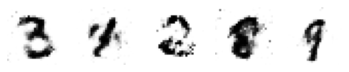

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7462 - g_acc: 0.2387 - d_loss: 1.0348 - g_loss: 1.1900
Epoch 8/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7440 - g_acc: 0.2413 - d_loss: 1.0379 - g_loss: 1.1845

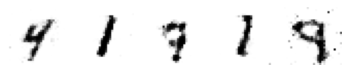

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7440 - g_acc: 0.2413 - d_loss: 1.0379 - g_loss: 1.1845
Epoch 9/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7413 - g_acc: 0.2428 - d_loss: 1.0456 - g_loss: 1.1761

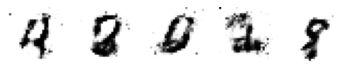

469/469 [==============================] - 2s 5ms/step - d_acc: 0.7413 - g_acc: 0.2428 - d_loss: 1.0456 - g_loss: 1.1761
Epoch 10/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7437 - g_acc: 0.2421 - d_loss: 1.0402 - g_loss: 1.1797

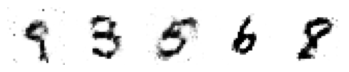

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7440 - g_acc: 0.2420 - d_loss: 1.0397 - g_loss: 1.1799
Epoch 11/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.7458 - g_acc: 0.2391 - d_loss: 1.0354 - g_loss: 1.1834

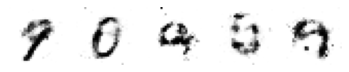

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7457 - g_acc: 0.2396 - d_loss: 1.0355 - g_loss: 1.1833
Epoch 12/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7412 - g_acc: 0.2431 - d_loss: 1.0415 - g_loss: 1.1794

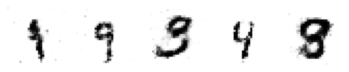

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7412 - g_acc: 0.2430 - d_loss: 1.0417 - g_loss: 1.1799
Epoch 13/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7427 - g_acc: 0.2437 - d_loss: 1.0397 - g_loss: 1.1917

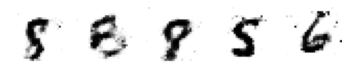

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7428 - g_acc: 0.2436 - d_loss: 1.0396 - g_loss: 1.1913
Epoch 14/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7407 - g_acc: 0.2434 - d_loss: 1.0436 - g_loss: 1.1840

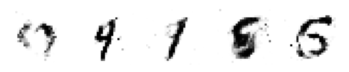

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7402 - g_acc: 0.2438 - d_loss: 1.0445 - g_loss: 1.1849
Epoch 15/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7413 - g_acc: 0.2419 - d_loss: 1.0464 - g_loss: 1.1764

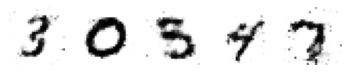

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7411 - g_acc: 0.2420 - d_loss: 1.0468 - g_loss: 1.1760
Epoch 16/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7384 - g_acc: 0.2453 - d_loss: 1.0499 - g_loss: 1.1787

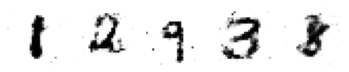

469/469 [==============================] - 3s 5ms/step - d_acc: 0.7380 - g_acc: 0.2463 - d_loss: 1.0507 - g_loss: 1.1778
Epoch 17/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7375 - g_acc: 0.2449 - d_loss: 1.0536 - g_loss: 1.1706

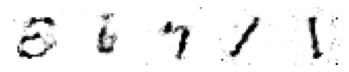

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7374 - g_acc: 0.2449 - d_loss: 1.0536 - g_loss: 1.1711
Epoch 18/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7363 - g_acc: 0.2458 - d_loss: 1.0571 - g_loss: 1.1683

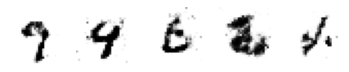

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7363 - g_acc: 0.2454 - d_loss: 1.0571 - g_loss: 1.1693
Epoch 19/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7376 - g_acc: 0.2472 - d_loss: 1.0520 - g_loss: 1.1762

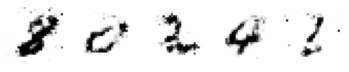

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7375 - g_acc: 0.2468 - d_loss: 1.0524 - g_loss: 1.1767
Epoch 20/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7370 - g_acc: 0.2451 - d_loss: 1.0502 - g_loss: 1.1728

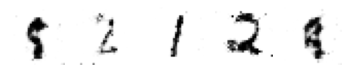

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7366 - g_acc: 0.2456 - d_loss: 1.0512 - g_loss: 1.1728
Epoch 21/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7356 - g_acc: 0.2452 - d_loss: 1.0560 - g_loss: 1.1724

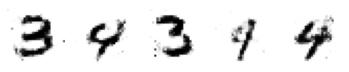

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7358 - g_acc: 0.2449 - d_loss: 1.0558 - g_loss: 1.1721
Epoch 22/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7341 - g_acc: 0.2483 - d_loss: 1.0581 - g_loss: 1.1699

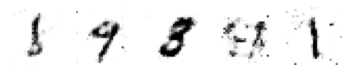

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7342 - g_acc: 0.2482 - d_loss: 1.0579 - g_loss: 1.1702
Epoch 23/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7330 - g_acc: 0.2512 - d_loss: 1.0612 - g_loss: 1.1708

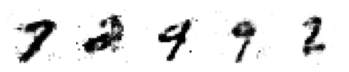

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7331 - g_acc: 0.2509 - d_loss: 1.0610 - g_loss: 1.1709
Epoch 24/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7354 - g_acc: 0.2479 - d_loss: 1.0585 - g_loss: 1.1742

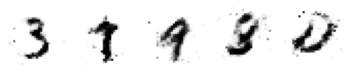

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7353 - g_acc: 0.2483 - d_loss: 1.0585 - g_loss: 1.1737
Epoch 25/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.7317 - g_acc: 0.2522 - d_loss: 1.0634 - g_loss: 1.1688

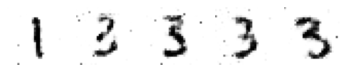

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7314 - g_acc: 0.2524 - d_loss: 1.0640 - g_loss: 1.1692
Epoch 26/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7328 - g_acc: 0.2506 - d_loss: 1.0647 - g_loss: 1.1695

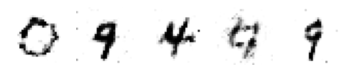

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7325 - g_acc: 0.2511 - d_loss: 1.0651 - g_loss: 1.1701
Epoch 27/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7302 - g_acc: 0.2541 - d_loss: 1.0665 - g_loss: 1.1708

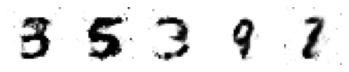

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7305 - g_acc: 0.2536 - d_loss: 1.0663 - g_loss: 1.1702
Epoch 28/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7321 - g_acc: 0.2529 - d_loss: 1.0663 - g_loss: 1.1668

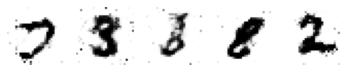

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7321 - g_acc: 0.2528 - d_loss: 1.0661 - g_loss: 1.1672
Epoch 29/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7332 - g_acc: 0.2527 - d_loss: 1.0652 - g_loss: 1.1694

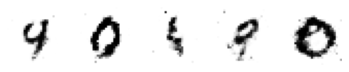

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7334 - g_acc: 0.2523 - d_loss: 1.0648 - g_loss: 1.1695
Epoch 30/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7296 - g_acc: 0.2545 - d_loss: 1.0711 - g_loss: 1.1631

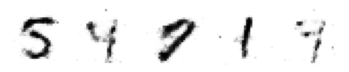

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7294 - g_acc: 0.2550 - d_loss: 1.0713 - g_loss: 1.1634
Epoch 31/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7272 - g_acc: 0.2590 - d_loss: 1.0758 - g_loss: 1.1672

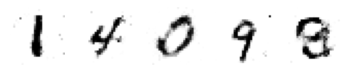

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7272 - g_acc: 0.2590 - d_loss: 1.0759 - g_loss: 1.1680
Epoch 32/50
461/469 [============================>.] - ETA: 0s - d_acc: 0.7298 - g_acc: 0.2534 - d_loss: 1.0704 - g_loss: 1.1656

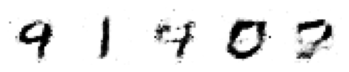

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7302 - g_acc: 0.2529 - d_loss: 1.0697 - g_loss: 1.1655
Epoch 33/50
463/469 [============================>.] - ETA: 0s - d_acc: 0.7273 - g_acc: 0.2574 - d_loss: 1.0752 - g_loss: 1.1671

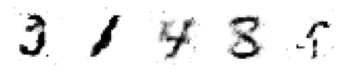

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7272 - g_acc: 0.2573 - d_loss: 1.0754 - g_loss: 1.1674
Epoch 34/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7300 - g_acc: 0.2524 - d_loss: 1.0702 - g_loss: 1.1630

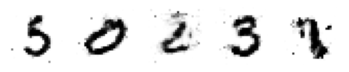

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7298 - g_acc: 0.2525 - d_loss: 1.0704 - g_loss: 1.1630
Epoch 35/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.7262 - g_acc: 0.2582 - d_loss: 1.0785 - g_loss: 1.1650

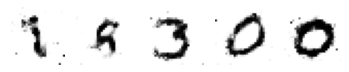

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7262 - g_acc: 0.2579 - d_loss: 1.0784 - g_loss: 1.1654
Epoch 36/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7273 - g_acc: 0.2545 - d_loss: 1.0762 - g_loss: 1.1611

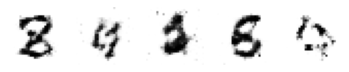

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7270 - g_acc: 0.2548 - d_loss: 1.0768 - g_loss: 1.1616
Epoch 37/50
466/469 [============================>.] - ETA: 0s - d_acc: 0.7228 - g_acc: 0.2610 - d_loss: 1.0818 - g_loss: 1.1615

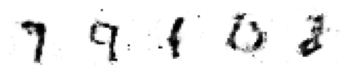

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7229 - g_acc: 0.2608 - d_loss: 1.0815 - g_loss: 1.1620
Epoch 38/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7253 - g_acc: 0.2583 - d_loss: 1.0806 - g_loss: 1.1633

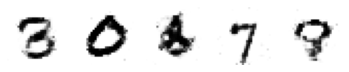

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7255 - g_acc: 0.2581 - d_loss: 1.0802 - g_loss: 1.1633
Epoch 39/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.7242 - g_acc: 0.2597 - d_loss: 1.0835 - g_loss: 1.1541

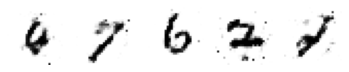

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7241 - g_acc: 0.2601 - d_loss: 1.0838 - g_loss: 1.1535
Epoch 40/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7234 - g_acc: 0.2603 - d_loss: 1.0813 - g_loss: 1.1619

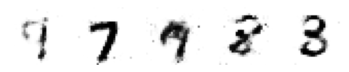

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7233 - g_acc: 0.2604 - d_loss: 1.0815 - g_loss: 1.1619
Epoch 41/50
462/469 [============================>.] - ETA: 0s - d_acc: 0.7243 - g_acc: 0.2605 - d_loss: 1.0844 - g_loss: 1.1605

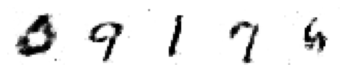

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7243 - g_acc: 0.2607 - d_loss: 1.0841 - g_loss: 1.1605
Epoch 42/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7231 - g_acc: 0.2615 - d_loss: 1.0842 - g_loss: 1.1622

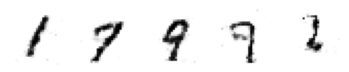

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7232 - g_acc: 0.2614 - d_loss: 1.0841 - g_loss: 1.1625
Epoch 43/50
465/469 [============================>.] - ETA: 0s - d_acc: 0.7242 - g_acc: 0.2606 - d_loss: 1.0836 - g_loss: 1.1614

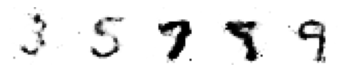

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7243 - g_acc: 0.2605 - d_loss: 1.0835 - g_loss: 1.1610
Epoch 44/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7224 - g_acc: 0.2631 - d_loss: 1.0843 - g_loss: 1.1578

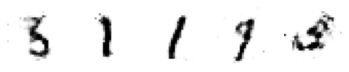

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7224 - g_acc: 0.2631 - d_loss: 1.0843 - g_loss: 1.1578
Epoch 45/50
467/469 [============================>.] - ETA: 0s - d_acc: 0.7234 - g_acc: 0.2626 - d_loss: 1.0850 - g_loss: 1.1615

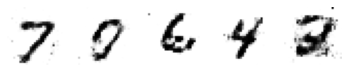

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7236 - g_acc: 0.2623 - d_loss: 1.0845 - g_loss: 1.1619
Epoch 46/50
468/469 [============================>.] - ETA: 0s - d_acc: 0.7224 - g_acc: 0.2622 - d_loss: 1.0850 - g_loss: 1.1570

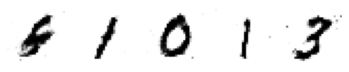

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7224 - g_acc: 0.2620 - d_loss: 1.0851 - g_loss: 1.1573
Epoch 47/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7223 - g_acc: 0.2624 - d_loss: 1.0885 - g_loss: 1.1572

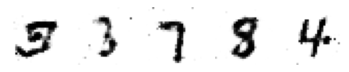

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7223 - g_acc: 0.2624 - d_loss: 1.0885 - g_loss: 1.1572
Epoch 48/50
460/469 [============================>.] - ETA: 0s - d_acc: 0.7251 - g_acc: 0.2605 - d_loss: 1.0829 - g_loss: 1.1602

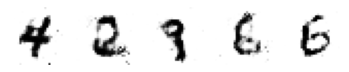

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7249 - g_acc: 0.2605 - d_loss: 1.0833 - g_loss: 1.1607
Epoch 49/50
469/469 [==============================] - ETA: 0s - d_acc: 0.7212 - g_acc: 0.2646 - d_loss: 1.0864 - g_loss: 1.1551

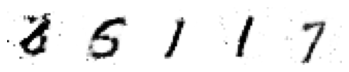

469/469 [==============================] - 3s 6ms/step - d_acc: 0.7212 - g_acc: 0.2646 - d_loss: 1.0864 - g_loss: 1.1551
Epoch 50/50
464/469 [============================>.] - ETA: 0s - d_acc: 0.7234 - g_acc: 0.2601 - d_loss: 1.0843 - g_loss: 1.1574

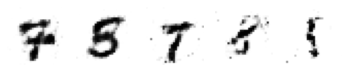

469/469 [==============================] - 3s 7ms/step - d_acc: 0.7231 - g_acc: 0.2601 - d_loss: 1.0847 - g_loss: 1.1576


In [ ]:
gan.fit(x_train.reshape(-1, 28 * 28), epochs=50, batch_size=128, callbacks=[Monitor()])

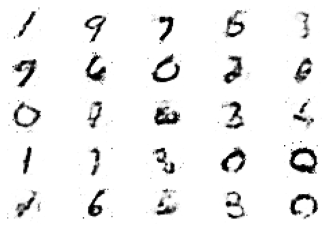

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_test = np.random.normal(size=2500).reshape(25, 100)
images = generator.predict(x_test)
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(images[i].reshape(28, 28), cmap='gray_r')